<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/CatsDogsKerasPretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats & Dogs Keras Pre-Trained
* We'll use a pre-trained model in the Cats & Dogs classification
* This will use VGG16
* Apply data augmentation
* We'll run it two ways
  * Feature Extraction (stack our model on VGG, freeze & fit)
  * Fine Tuning (stack our model on VGG, unfreeze top layers & fit)

# Setup

In [0]:
from zipfile import ZipFile
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers

1.15.0


Using TensorFlow backend.


# Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/Data/CatsDogs/data.zip"
file   = "/content/drive/My Drive/Data/CatsDogs/data.zip"

'/content/drive/My Drive/Data/CatsDogs/data.zip'


In [0]:
!mkdir -p /tmp/catdog
with ZipFile(file, 'r') as zip: 
  zip.extractall('/tmp/catdog/')

In [0]:
base_dir       = '/tmp/catdog/'
test_dir       = '/tmp/catdog/test/'
training_dir   = '/tmp/catdog/training/'
validation_dir = '/tmp/catdog/validation/'

!mkdir -p "$base_dir"

!rm -fr "$test_dir"
!mkdir -p "$test_dir"
!mkdir -p "$test_dir/cats"
!mkdir -p "$test_dir/dogs"

!rm -fr "$training_dir"
!mkdir -p "$training_dir"
!mkdir -p "$training_dir/cats"
!mkdir -p "$training_dir/dogs"

!rm -fr "$validation_dir"
!mkdir -p "$validation_dir"
!mkdir -p "$validation_dir/cats"
!mkdir -p "$validation_dir/dogs"

# Images

In [0]:
range_train = 1000
range_validation = 1500
range_test = 2000

In [0]:
def copyFiles(prefix, dest, start, end):
  if prefix != 'cat' and prefix != 'dog':
    raise ValueError('Must pass cat or dog for prefix')
  srcFolder  = os.path.join(base_dir, 'train')
  destFolder = os.path.join(base_dir, dest, prefix + 's')
  print(srcFolder, '->', destFolder, start, end)
  for file in  ['{}.{}.jpg'.format(prefix, index) for index in range(start, end)]:
    shutil.copy(os.path.join(srcFolder, file), os.path.join(destFolder, file))

In [9]:
copyFiles('cat', 'training', 0, range_train)
copyFiles('cat', 'validation', range_train, range_validation)
copyFiles('cat', 'test', range_validation, range_test)

copyFiles('dog', 'training', 0, range_train)
copyFiles('dog', 'validation', range_train, range_validation)
copyFiles('dog', 'test', range_validation, range_test)

/tmp/catdog/train -> /tmp/catdog/training/cats 0 1000
/tmp/catdog/train -> /tmp/catdog/validation/cats 1000 1500
/tmp/catdog/train -> /tmp/catdog/test/cats 1500 2000
/tmp/catdog/train -> /tmp/catdog/training/dogs 0 1000
/tmp/catdog/train -> /tmp/catdog/validation/dogs 1000 1500
/tmp/catdog/train -> /tmp/catdog/test/dogs 1500 2000


# Model


## Load Pretrained
* Drop the final layer -> 1000
* Declare the input shape

In [33]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Layer Cats / Dogs

In [34]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


# Train

In [44]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               shear_range=0.2,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen       = ImageDataGenerator(rescale=1. / 255)

print(training_dir)
train_gen = train_datagen.flow_from_directory(
  training_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

print(validation_dir)
validation_gen = validation_datagen.flow_from_directory(
  validation_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary')

print(test_dir)
test_gen = test_datagen.flow_from_directory(
  test_dir,
  target_size=(150, 150),
  batch_size=20,
  class_mode='binary', 
  shuffle=False) # Don't shuffle predictions

/tmp/catdog/training/
Found 2000 images belonging to 2 classes.
/tmp/catdog/validation/
Found 1000 images belonging to 2 classes.
/tmp/catdog/test/
Found 1000 images belonging to 2 classes.


# Fit - Feature Extraction

In [0]:
base_model.trainable = False

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [47]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_gen,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 17s 173ms/step - loss: 0.4035 - acc: 0.8295 - val_loss: 0.2466 - val_acc: 0.9140
Epoch 2/30
100/100 [==============================] - 16s 159ms/step - loss: 0.3376 - acc: 0.8625 - val_loss: 0.2419 - val_acc: 0.9090
Epoch 3/30
100/100 [==============================] - 15s 153ms/step - loss: 0.3176 - acc: 0.8590 - val_loss: 0.2323 - val_acc: 0.9070
Epoch 4/30
100/100 [==============================] - 15s 152ms/step - loss: 0.3087 - acc: 0.8620 - val_loss: 0.2286 - val_acc: 0.9090
Epoch 5/30
100/100 [==============================] - 15s 154ms/step - loss: 0.3002 - acc: 0.8695 - val_loss: 0.2325 - val_acc: 0.9070
Epoch 6/30
100/100 [==============================] - 15s 151ms/step - loss: 0.2961 - acc: 0.8705 - val_loss: 0.2266 - val_acc: 0.9060
Epoch 7/30
100/100 [==============================] - 16s 155ms/step - loss: 0.2905 - acc: 0.8785 - val_loss: 0.2276 - val_acc: 0.9060
Epoch 8/30
100/100 [==============================] - 1

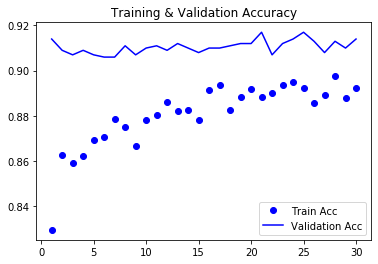

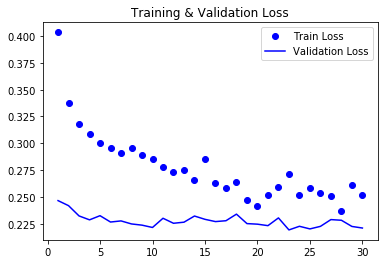

In [48]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Train Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Fine Tuning

In [49]:
base_model.trainable = True
flag = False
for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    flag = True
  if flag == True:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in base_model.layers:
  print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [51]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_gen,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 17s 172ms/step - loss: 0.2785 - acc: 0.8765 - val_loss: 0.2122 - val_acc: 0.9170
Epoch 2/100
100/100 [==============================] - 15s 155ms/step - loss: 0.2367 - acc: 0.8970 - val_loss: 0.2214 - val_acc: 0.9160
Epoch 3/100
100/100 [==============================] - 16s 155ms/step - loss: 0.2162 - acc: 0.9085 - val_loss: 0.2021 - val_acc: 0.9240
Epoch 4/100
100/100 [==============================] - 16s 157ms/step - loss: 0.1925 - acc: 0.9190 - val_loss: 0.1926 - val_acc: 0.9310
Epoch 5/100
100/100 [==============================] - 16s 156ms/step - loss: 0.1838 - acc: 0.9185 - val_loss: 0.1988 - val_acc: 0.9300
Epoch 6/100
100/100 [==============================] - 16s 157ms/step - loss: 0.1810 - acc: 0.9270 - val_loss: 0.1931 - val_acc: 0.9280
Epoch 7/100
100/100 [==============================] - 16s 157ms/step - loss: 0.1727 - acc: 0.9290 - val_loss: 0.2024 - val_acc: 0.9260
Epoch 8/100
100/100 [===========================

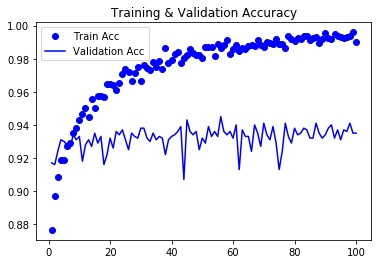

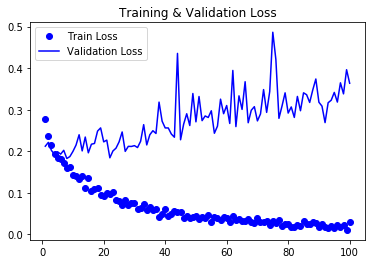

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Train Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Evaluate Test

In [53]:
test_loss, test_acc = model.evaluate_generator(test_gen, steps=50)
print('Test Accuracy {:.4f}'.format(test_acc))

Test Accuracy 0.9380


# Conclusion
* Feature Generation acheives 91.4% validation accuracy  
* Fine Tuning achieves higher accuracy 93.5% on validation, 93.8% on Test